In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as Data
import torch.nn.utils.rnn as rnn_utils
from torch.autograd import Variable

device = torch.device("cuda",0)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score

In [2]:
def pred(data_iter, net):
    y_pred = []
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
#         print(outputs.argmax(dim=1),
#              outputs.argmax(dim=1)==y,
#              (outputs.argmax(dim=1)==y).float(),
#              (outputs.argmax(dim=1)==y).float().sum(),
#              (outputs.argmax(dim=1)==y).float().sum().item())
        for _ in outputs.argmax(dim=1):
            y_pred.append(int(_))
    return y_pred

def pred_prob(data_iter, net):
    y_pred = []
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
        for _ in outputs:
            y_pred.append(list(map(float, _)))
    return y_pred

class newModel(nn.Module):
    def __init__(self, vocab_size=24):
        super().__init__()
        self.hidden_dim = 25
        self.batch_size = 256
        self.emb_dim = 512
        
        self.embedding = nn.Embedding(vocab_size, self.emb_dim, padding_idx=0)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        
        self.gru = nn.GRU(self.emb_dim, self.hidden_dim, num_layers=2, 
                               bidirectional=True, dropout=0.2)
        
        
        self.block1=nn.Sequential(nn.Linear(4050,1024),
                                            nn.BatchNorm1d(1024),
                                            nn.LeakyReLU(),
                                            nn.Linear(1024,256),
                                 )

        self.block2=nn.Sequential(
                                               nn.BatchNorm1d(256),
                                               nn.LeakyReLU(),
                                               nn.Linear(256,128),
                                               nn.BatchNorm1d(128),
                                               nn.LeakyReLU(),
                                               nn.Linear(128,64),
                                               nn.BatchNorm1d(64),
                                               nn.LeakyReLU(),
                                               nn.Linear(64,2)
                                            )
        
    def forward(self, x):
        x=self.embedding(x)
        output=self.transformer_encoder(x).permute(1, 0, 2)
        output,hn=self.gru(output)
        output=output.permute(1,0,2)
        hn=hn.permute(1,0,2)
        output=output.reshape(output.shape[0],-1)
        hn=hn.reshape(output.shape[0],-1)
        output=torch.cat([output,hn],1)
        return self.block1(output)

    def trainModel(self, x):
        with torch.no_grad():
            output=self.forward(x)
        return self.block2(output)

In [3]:
import sys
sys.path.append('/home/bis/2021_SJH_detectability/DbyDeep')
from RefModel.model_PepFormer import newModel, evaluate_accuracy, genData

In [4]:
net = newModel().to(device)  # retrained
net.load_state_dict(torch.load(f'/home/bis/2021_SJH_detectability/DbyDeep/log/model_PepFormer.pl')['model'])
net.eval()

newModel(
  (embedding): Embedding(24, 512, padding_idx=0)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=Fals

In [5]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(net)

8867506

In [6]:
df_massive=pd.read_csv('/data/2021_SJH_detectability/data_human/train.csv')
df_merge=pd.DataFrame(df_massive.peptide.unique(), columns=['peptide'])
df_merge['Drop']=True
df_hpp=pd.read_csv('/data/2021_SJH_detectability/data_human/HPP.csv')

# Cross species : Mouse

length > 40: 0
Test AUC : 0.9088435678177489
              precision    recall  f1-score   support

           0     0.9967    0.6738    0.8041   1201512
           1     0.1151    0.9497    0.2054     53697

    accuracy                         0.6856   1255209
   macro avg     0.5559    0.8118    0.5047   1255209
weighted avg     0.9590    0.6856    0.7784   1255209



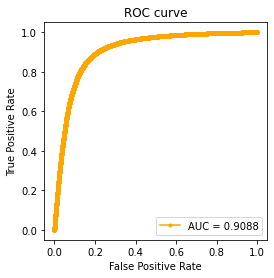

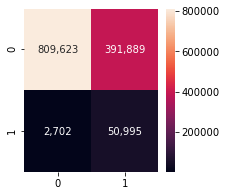

In [7]:
tmp = pd.read_csv('/data/2021_SJH_detectability/diff_tool/mouse_eph4/data.csv')
tmp=tmp.merge(df_merge, how='left')
tmp.Drop.fillna(False, inplace=True)
idxes=tmp.loc[tmp.Drop==True].index
tmp=tmp.drop(idxes, axis=0).reset_index(drop=True)
tmp=tmp.drop(['Drop'],axis=1)
tmp=tmp[['peptide', 'label']]#.drop_duplicates()

tmp = tmp[tmp.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
tmp = tmp[tmp.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)

tmp['label'] = tmp['label'].apply(lambda x: {True: str(1), False: str(0)}[x])
test = []
for line in tmp.values:
    line = ','.join(line)
    test.append(line)

test_data, test_label = genData(test, 40)
test_data = test_data[:-1]
test_label = test_label[:-1]
test_dataset = Data.TensorDataset(test_data, test_label)
batch_size=256
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

y_pred = pred(test_iter, net)
probs = np.array(pred_prob(test_iter, net))[:, 1]

# acc = evaluate_accuracy(test_iter,net)
auc = roc_auc_score(test_label, probs)

# print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(test_label, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(test_label, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_mouse_KLife_PepFormer_fpr_msgfplus.npy', fpr)
np.save('log/result_mouse_KLife_PepFormer_tpr_msgfplus.npy', tpr)
np.save('log/result_mouse_KLife_PepFormer_threshold_msgfplus.npy', threshold)
np.save('log/result_mouse_KLife_PepFormer_prob_msgfplus.npy', probs)
np.save('log/result_mouse_KLife_PepFormer_true_msgfplus.npy', test_label)

length > 40: 0
Test AUC : 0.8771857268579399
              precision    recall  f1-score   support

           0     0.9951    0.6713    0.8018   1091665
           1     0.1097    0.9243    0.1961     47816

    accuracy                         0.6819   1139481
   macro avg     0.5524    0.7978    0.4989   1139481
weighted avg     0.9579    0.6819    0.7763   1139481



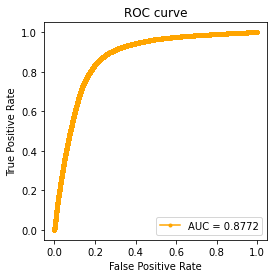

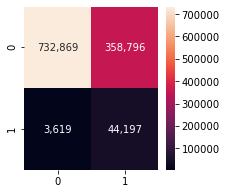

In [8]:
tmp = pd.read_csv('/data/2021_SJH_detectability/diff_tool/mouse_tmuscle/data.csv')
tmp=tmp.merge(df_merge, how='left')
tmp.Drop.fillna(False, inplace=True)
idxes=tmp.loc[tmp.Drop==True].index
tmp=tmp.drop(idxes, axis=0).reset_index(drop=True)
tmp=tmp.drop(['Drop'],axis=1)
tmp=tmp[['peptide', 'label']]#.drop_duplicates()

tmp = tmp[tmp.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
tmp = tmp[tmp.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)

tmp['label'] = tmp['label'].apply(lambda x: {True: str(1), False: str(0)}[x])
test = []
for line in tmp.values:
    line = ','.join(line)
    test.append(line)

test_data, test_label = genData(test, 40)
test_data = test_data[:-1]
test_label = test_label[:-1]
test_dataset = Data.TensorDataset(test_data, test_label)
batch_size=256
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

y_pred = pred(test_iter, net)
probs = np.array(pred_prob(test_iter, net))[:, 1]

# acc = evaluate_accuracy(test_iter,net)
auc = roc_auc_score(test_label, probs)

# print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(test_label, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(test_label, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_mouse_SkeletaMuscle_PepFormer_fpr_msgfplus.npy', fpr)
np.save('log/result_mouse_SkeletaMuscle_PepFormer_tpr_msgfplus.npy', tpr)
np.save('log/result_mouse_SkeletaMuscle_PepFormer_threshold_msgfplus.npy', threshold)
np.save('log/result_mouse_SkeletaMuscle_PepFormer_prob_msgfplus.npy', probs)
np.save('log/result_mouse_SkeletaMuscle_PepFormer_true_msgfplus.npy', test_label)

# Cross species : Human

length > 40: 0
Test AUC : 0.8771685273799548
              precision    recall  f1-score   support

           0     0.9940    0.7063    0.8258   1245378
           1     0.1082    0.8930    0.1930     49706

    accuracy                         0.7134   1295084
   macro avg     0.5511    0.7996    0.5094   1295084
weighted avg     0.9600    0.7134    0.8015   1295084



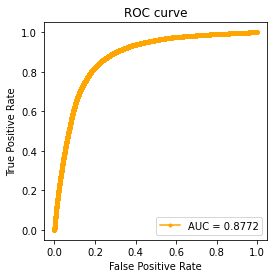

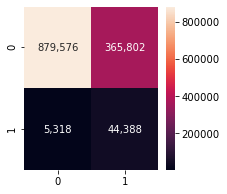

In [9]:
tmp = pd.read_csv('/data/2021_SJH_detectability/diff_tool/human_hek293/data.csv')
tmp=tmp.merge(df_merge, how='left')
tmp.Drop.fillna(False, inplace=True)
idxes=tmp.loc[tmp.Drop==True].index
tmp=tmp.drop(idxes, axis=0).reset_index(drop=True)
tmp=tmp.drop(['Drop'],axis=1)
tmp=tmp[['peptide', 'label']]#.drop_duplicates()

tmp['label'] = tmp['label'].apply(lambda x: {True: str(1), False: str(0)}[x])
test = []
for line in tmp.values:
    line = ','.join(line)
    test.append(line)

test_data, test_label = genData(test, 40)
test_data = test_data[:-1]
test_label = test_label[:-1]
test_dataset = Data.TensorDataset(test_data, test_label)
batch_size=256
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

y_pred = pred(test_iter, net)
probs = np.array(pred_prob(test_iter, net))[:, 1]

# acc = evaluate_accuracy(test_iter,net)
auc = roc_auc_score(test_label, probs)

# print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(test_label, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(test_label, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_human_HEK293_PepFormer_fpr_msgfplus.npy', fpr)
np.save('log/result_human_HEK293_PepFormer_tpr_msgfplus.npy', tpr)
np.save('log/result_human_HEK293_PepFormer_threshold_msgfplus.npy', threshold)
np.save('log/result_human_HEK293_PepFormer_prob_msgfplus.npy', probs)
np.save('log/result_human_HEK293_PepFormer_true_msgfplus.npy', test_label)

length > 40: 0
Test AUC : 0.8598763474769519
              precision    recall  f1-score   support

           0     0.9946    0.7110    0.8293    742100
           1     0.0676    0.8442    0.1251     18405

    accuracy                         0.7143    760505
   macro avg     0.5311    0.7776    0.4772    760505
weighted avg     0.9722    0.7143    0.8122    760505



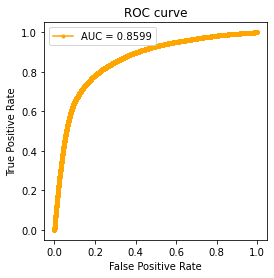

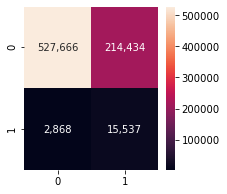

In [10]:
tmp = pd.read_csv('/data/2021_SJH_detectability/diff_tool/human_liver/data.csv')
tmp=tmp.merge(df_merge, how='left')
tmp.Drop.fillna(False, inplace=True)
idxes=tmp.loc[tmp.Drop==True].index
tmp=tmp.drop(idxes, axis=0).reset_index(drop=True)
tmp=tmp.drop(['Drop'],axis=1)
tmp=tmp[['peptide', 'label']]#.drop_duplicates()

tmp['label'] = tmp['label'].apply(lambda x: {True: str(1), False: str(0)}[x])
test = []
for line in tmp.values:
    line = ','.join(line)
    test.append(line)

test_data, test_label = genData(test, 40)
test_data = test_data[:-1]
test_label = test_label[:-1]
test_dataset = Data.TensorDataset(test_data, test_label)
batch_size=256
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

y_pred = pred(test_iter, net)
probs = np.array(pred_prob(test_iter, net))[:, 1]

# acc = evaluate_accuracy(test_iter,net)
auc = roc_auc_score(test_label, probs)

# print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(test_label, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(test_label, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_human_HmapLiver_PepFormer_fpr_msgfplus.npy', fpr)
np.save('log/result_human_HmapLiver_PepFormer_tpr_msgfplus.npy', tpr)
np.save('log/result_human_HmapLiver_PepFormer_threshold_msgfplus.npy', threshold)
np.save('log/result_human_HmapLiver_PepFormer_prob_msgfplus.npy', probs)
np.save('log/result_human_HmapLiver_PepFormer_true_msgfplus.npy', test_label)

# Cross species : Yeast

length > 40: 0
Test AUC : 0.9101377127006695
              precision    recall  f1-score   support

           0     0.9849    0.6932    0.8137    557308
           1     0.3115    0.9290    0.4666     83287

    accuracy                         0.7239    640595
   macro avg     0.6482    0.8111    0.6402    640595
weighted avg     0.8974    0.7239    0.7686    640595



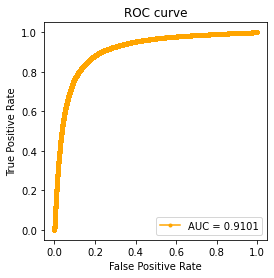

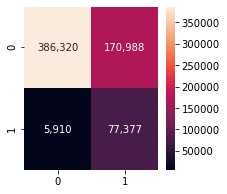

In [11]:
tmp = pd.read_csv('/data/2021_SJH_detectability/diff_tool/yeast_23/data.csv')
tmp=tmp.merge(df_merge, how='left')
tmp.Drop.fillna(False, inplace=True)
idxes=tmp.loc[tmp.Drop==True].index
tmp=tmp.drop(idxes, axis=0).reset_index(drop=True)
tmp=tmp.drop(['Drop'],axis=1)
tmp=tmp[['peptide', 'label']]#.drop_duplicates()

tmp['label'] = tmp['label'].apply(lambda x: {True: str(1), False: str(0)}[x])
test = []
for line in tmp.values:
    line = ','.join(line)
    test.append(line)

test_data, test_label = genData(test, 40)
test_data = test_data[:-1]
test_label = test_label[:-1]
test_dataset = Data.TensorDataset(test_data, test_label)
batch_size=256
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

y_pred = pred(test_iter, net)
probs = np.array(pred_prob(test_iter, net))[:, 1]

# acc = evaluate_accuracy(test_iter,net)
auc = roc_auc_score(test_label, probs)

# print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(test_label, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(test_label, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_yeast_DelPBP1_PepFormer_fpr_msgfplus.npy', fpr)
np.save('log/result_yeast_DelPBP1_PepFormer_tpr_msgfplus.npy', tpr)
np.save('log/result_yeast_DelPBP1_PepFormer_threshold_msgfplus.npy', threshold)
np.save('log/result_yeast_DelPBP1_PepFormer_prob_msgfplus.npy', probs)
np.save('log/result_yeast_DelPBP1_PepFormer_true_msgfplus.npy', test_label)

length > 40: 0
Test AUC : 0.8331420981950559
              precision    recall  f1-score   support

           0     0.9885    0.6403    0.7772    554972
           1     0.1297    0.8780    0.2260     33886

    accuracy                         0.6540    588858
   macro avg     0.5591    0.7592    0.5016    588858
weighted avg     0.9391    0.6540    0.7455    588858



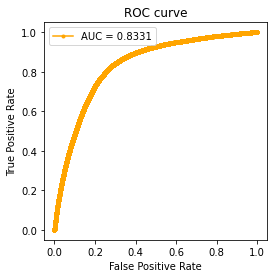

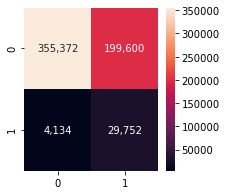

In [12]:
tmp = pd.read_csv('/data/2021_SJH_detectability/diff_tool/yeast_25/data.csv')
tmp=tmp.merge(df_merge, how='left')
tmp.Drop.fillna(False, inplace=True)
idxes=tmp.loc[tmp.Drop==True].index
tmp=tmp.drop(idxes, axis=0).reset_index(drop=True)
tmp=tmp.drop(['Drop'],axis=1)
tmp=tmp[['peptide', 'label']]#.drop_duplicates()

tmp['label'] = tmp['label'].apply(lambda x: {True: str(1), False: str(0)}[x])
test = []
for line in tmp.values:
    line = ','.join(line)
    test.append(line)

test_data, test_label = genData(test, 40)
test_data = test_data[:-1]
test_label = test_label[:-1]
test_dataset = Data.TensorDataset(test_data, test_label)
batch_size=256
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

y_pred = pred(test_iter, net)
probs = np.array(pred_prob(test_iter, net))[:, 1]

# acc = evaluate_accuracy(test_iter,net)
auc = roc_auc_score(test_label, probs)

# print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(test_label, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(test_label, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_yeast_KLife_PepFormer_fpr_msgfplus.npy', fpr)
np.save('log/result_yeast_KLife_PepFormer_tpr_msgfplus.npy', tpr)
np.save('log/result_yeast_KLife_PepFormer_threshold_msgfplus.npy', threshold)
np.save('log/result_yeast_KLife_PepFormer_prob_msgfplus.npy', probs)
np.save('log/result_yeast_KLife_PepFormer_true_msgfplus.npy', test_label)